In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Input,Conv2D,Activation,BatchNormalization,Add,Multiply,Concatenate,GlobalAveragePooling2D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model

In [6]:
train_files=['images/train/'+filename for filename in os.listdir('images/train')]
test_files=['images/test/'+filename for filename in os.listdir('images/test')]

In [7]:
def _parse_function(filename):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.cast(image_decoded, tf.float32)/255.
    resize_image = tf.image.resize(image, [40,40])
    image=resize_image
    
    noise_level=np.random.choice(NOISE_LEVELS)
    noisy_image=image+tf.random.normal(shape=(40,40,3),mean=0,stddev=noise_level/255)
    noisy_image=tf.clip_by_value(noisy_image, clip_value_min=0., clip_value_max=1.)

    return noisy_image,image

In [8]:
BATCH_SIZE=64
NOISE_LEVELS=[15,25,50] 

train_dataset = tf.data.Dataset.from_tensor_slices(np.array(train_files)) 
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices(np.array(test_files))
test_dataset = test_dataset.map(_parse_function)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [11]:
iterator = iter(train_dataset)
x, y = iterator.get_next()

print('Single batch size of x : ',a.shape)
print('Single batch size of y : ',b.shape)

Single batch size of x :  (64, 40, 40, 3)
Single batch size of y :  (64, 40, 40, 3)


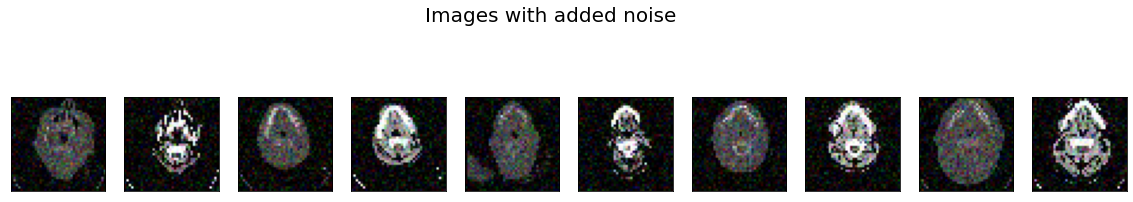

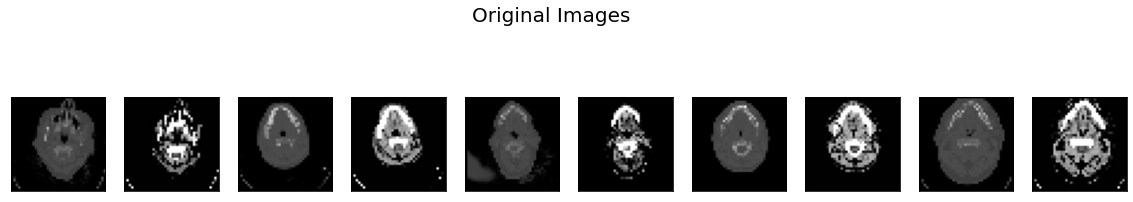

In [12]:
#Plotting the images from dataset to verify the dataset
fig, axs = plt.subplots(1,10,figsize=(20,4))
for i in range(10):
  axs[i].imshow(a[i])
  axs[i].get_xaxis().set_visible(False)
  axs[i].get_yaxis().set_visible(False)
fig.suptitle('Images with added noise',fontsize=20)
plt.show()
fig, axs = plt.subplots(1,10,figsize=(20,4))
for i in range(10):
  axs[i].imshow(b[i])
  axs[i].get_xaxis().set_visible(False)
  axs[i].get_yaxis().set_visible(False)
fig.suptitle('Original Images',fontsize=20)
plt.show()

In [12]:
def get_patches(file_name,patch_size,crop_sizes):
    '''This functions creates and return patches of given image with a specified patch_size'''
    image = cv2.imread(file_name) 
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    height, width , channels= image.shape
    patches = []
    for crop_size in crop_sizes: #We will crop the image to different sizes
        crop_h, crop_w = int(height*crop_size),int(width*crop_size)
        image_scaled = cv2.resize(image, (crop_w,crop_h), interpolation=cv2.INTER_CUBIC)
        for i in range(0, crop_h-patch_size+1, patch_size):
            for j in range(0, crop_w-patch_size+1, patch_size):
                x = image_scaled[i:i+patch_size, j:j+patch_size] # This gets the patch from the original image with size patch_size x patch_size
                patches.append(x)
    return patches

def create_image_from_patches(patches,image_shape):
  '''This function takes the patches of images and reconstructs the image'''
  image=np.zeros(image_shape) # Create a image with all zeros with desired image shape
  patch_size=patches.shape[1]
  p=0
  for i in range(0,image.shape[0]-patch_size+1,patch_size):
    for j in range(0,image.shape[1]-patch_size+1,patch_size):
      image[i:i+patch_size,j:j+patch_size]=patches[p] # Assigning values of pixels from patches to image
      p+=1
  return np.array(image)

def predict_fun(model,image_path,noise_level=30):
  #Creating patches for test image
  patches=get_patches(image_path,40,[1])
  test_image=cv2.imread(image_path)

  patches=np.array(patches)
  ground_truth=create_image_from_patches(patches,test_image.shape)

  #predicting the output on the patches of test image
  patches = patches.astype('float32') /255.
  patches_noisy = patches+ tf.random.normal(shape=patches.shape,mean=0,stddev=noise_level/255) 
  patches_noisy = tf.clip_by_value(patches_noisy, clip_value_min=0., clip_value_max=1.)
  noisy_image=create_image_from_patches(patches_noisy,test_image.shape)

  denoised_patches=model.predict(patches_noisy)
  denoised_patches=tf.clip_by_value(denoised_patches, clip_value_min=0., clip_value_max=1.)

  #Creating entire denoised image from denoised patches
  denoised_image=create_image_from_patches(denoised_patches,test_image.shape)

  return patches_noisy,denoised_patches,ground_truth/255.,noisy_image,denoised_image


def plot_patches(patches_noisy,denoised_patches):
  fig, axs = plt.subplots(2,10,figsize=(20,4))
  for i in range(10):

    axs[0,i].imshow(patches_noisy[i])
    axs[0,i].title.set_text(' Noisy')
    axs[0,i].get_xaxis().set_visible(False)
    axs[0,i].get_yaxis().set_visible(False)

    axs[1,i].imshow(denoised_patches[i])
    axs[1,i].title.set_text('Denoised')
    axs[1,i].get_xaxis().set_visible(False)
    axs[1,i].get_yaxis().set_visible(False)
  plt.show()

def plot_predictions(ground_truth,noisy_image,denoised_image):
  fig, axs = plt.subplots(1,3,figsize=(15,15))
  axs[0].imshow(ground_truth)
  axs[0].title.set_text('Ground Truth')
  axs[1].imshow(noisy_image)
  axs[1].title.set_text('Noisy Image')
  axs[2].imshow(denoised_image)
  axs[2].title.set_text('Denoised Image')
  plt.show()


#https://www.geeksforgeeks.org/python-peak-signal-to-noise-ratio-psnr/
def PSNR(gt, image, max_value=1):
    """"Function to calculate peak signal-to-noise ratio (PSNR) between two images."""
    mse = np.mean((gt - image) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(max_value / (np.sqrt(mse)))

In [8]:
def EAM(input):

  x=Conv2D(64, (3,3), dilation_rate=1,padding='same',activation='relu')(input)
  x=Conv2D(64, (3,3), dilation_rate=2,padding='same',activation='relu')(x)

  y=Conv2D(64, (3,3), dilation_rate=3,padding='same',activation='relu')(input)
  y=Conv2D(64, (3,3), dilation_rate=4,padding='same',activation='relu')(y)

  z=Concatenate(axis=-1)([x,y])
  z=Conv2D(64, (3,3),padding='same',activation='relu')(z)
  add_1=Add()([z, input])

  z=Conv2D(64, (3,3),padding='same',activation='relu')(add_1)
  z=Conv2D(64, (3,3),padding='same')(z)
  add_2=Add()([z,add_1])
  add_2 = Activation('relu')(add_2)

  z=Conv2D(64, (3,3),padding='same',activation='relu')(add_2)
  z=Conv2D(64, (3,3),padding='same',activation='relu')(z)
  z=Conv2D(64, (1,1),padding='same')(z)
  add_3=Add()([z,add_2])
  add_3 = Activation('relu')(add_3)

  z = GlobalAveragePooling2D()(add_3)
  z = tf.expand_dims(z,1)
  z = tf.expand_dims(z,1)
  z=Conv2D(4, (3,3),padding='same',activation='relu')(z)
  z=Conv2D(64, (3,3),padding='same',activation='sigmoid')(z)
  mul=Multiply()([z, add_3])

  return mul

In [9]:
def RIDNET():

  input = Input((40, 40, 3),name='input')
  feat_extraction =Conv2D(64, (3,3),padding='same')(input)
  eam_1=EAM(feat_extraction)
  eam_2=EAM(eam_1)
  eam_3=EAM(eam_2)
  eam_4=EAM(eam_3)
  x=Conv2D(3, (3,3),padding='same')(eam_4)
  add_2=Add()([x, input])
  
  model=Model(input,add_2)

  return model

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(6908)
ridnet = RIDNET()

In [11]:
ridnet.compile(optimizer=tf.keras.optimizers.Adam(1e-03), loss=tf.keras.losses.MeanAbsoluteError())

In [12]:
ridnet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 40, 40, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 40, 40, 64)   1792        input[0][0]                      
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 40, 40, 64)   36928       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 40, 40, 64)   36928       conv2d[0][0]                     
______________________________________________________________________________________________

In [13]:
def scheduler(epoch,lr):
  return lr*0.9

In [16]:
ridnet.fit( train_dataset,shuffle=True,epochs=20,validation_data= test_dataset)

Epoch 1/20
16/16 [==============================] - 131s 8s/step - loss: 0.1001 - val_loss: 0.0510
Epoch 2/20
16/16 [==============================] - 148s 9s/step - loss: 0.0971 - val_loss: 0.0480
Epoch 3/20
16/16 [==============================] - 159s 10s/step - loss: 0.0948 - val_loss: 0.0470
Epoch 4/20
16/16 [==============================] - 148s 9s/step - loss: 0.0895 - val_loss: 0.0467
Epoch 5/20
16/16 [==============================] - 148s 9s/step - loss: 0.0824 - val_loss: 0.0426
Epoch 6/20
16/16 [==============================] - 151s 9s/step - loss: 0.0732 - val_loss: 0.0454
Epoch 7/20
16/16 [==============================] - 153s 10s/step - loss: 0.0612 - val_loss: 0.0476
Epoch 8/20
16/16 [==============================] - 155s 10s/step - loss: 0.0547 - val_loss: 0.0656
Epoch 9/20
16/16 [==============================] - 154s 10s/step - loss: 0.0511 - val_loss: 0.0422
Epoch 10/20
16/16 [==============================] - 157s 10s/step - loss: 0.0461 - val_loss: 0.0395
Epoc

PSNR of Noisy Image :  14.378988407342497
PSNR of Denoised Image :  24.543618635555116


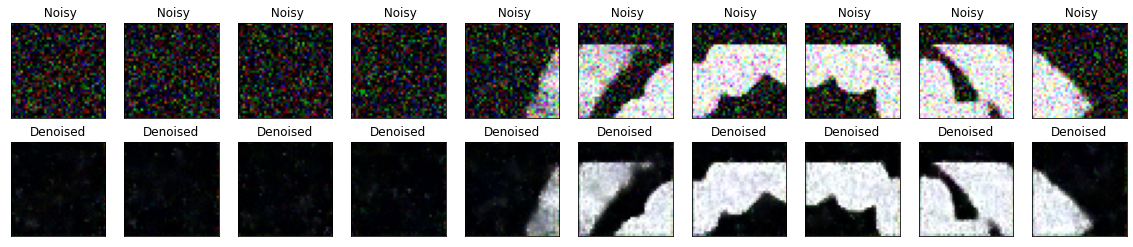

In [17]:
patches_noisy,denoised_patches,ground_truth,noisy_image,denoised_image=predict_fun(ridnet,'images/test/2 (2).jpg',noise_level=65)
print('PSNR of Noisy Image : ',PSNR(ground_truth,noisy_image))
print('PSNR of Denoised Image : ',PSNR(ground_truth,denoised_image))
plot_patches(patches_noisy,denoised_patches)

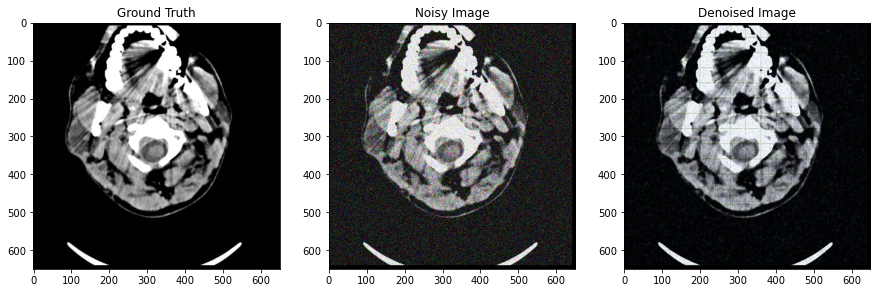

In [19]:
plot_predictions(ground_truth,noisy_image,denoised_image)

In [26]:
results=pd.DataFrame(columns=['Noise Level','RIDNET'])

In [13]:
def get_results(results,noise_level):
    patches_noisy_r,denoised_patches_r,ground_truth,noisy_image_r,denoised_image_r=predict_fun(ridnet,'images/test/2 (2).jpg',noise_level=noise_level)
    results.loc[len(results.index)]=[noise_level,PSNR(ground_truth,denoised_image_r)]
    return results

In [28]:
results=get_results(results,15)
results=get_results(results,20)
results=get_results(results,25)
results=get_results(results,30)
results=get_results(results,40)
results=get_results(results,45)

In [29]:
print('Tabulating the model results with different noise level \n')
results.head(6)

Tabulating the model results with different noise level 



,Noise Level,RIDNET
0,15.0,29.524987
1,20.0,29.246129
2,25.0,28.935994
3,30.0,28.601673
4,40.0,27.845395
5,45.0,27.339546


In [32]:
ridnet.save('ridnet.hd5')

G:\ANNACONDA\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: ridnet.hd5\assets


In [33]:
ridnet.save_weights('ridnetweights')


In [5]:
import tensorflow as tf
ridnet=tf.keras.models.load_model('ridnet.hd5')

In [6]:
from tensorflow.keras.utils import plot_model

In [10]:
# ! pip install pydot
# plot_model(ridnet,show_shapes=True,to_file='ridnet.png')

In [8]:
ridnet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 40, 40, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 40, 40, 64)   1792        input[0][0]                      
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 40, 40, 64)   36928       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 40, 40, 64)   36928       conv2d[0][0]                     
______________________________________________________________________________________________

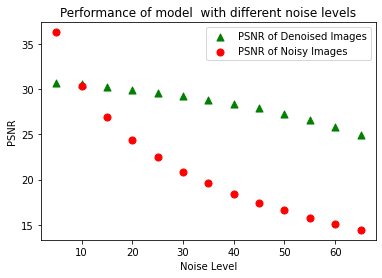

In [17]:
noise_levels=[i for i in range(5,70,5)]
psnr_noisy=[]
psnr_denoised=[]
for i in noise_levels:
  patches_noisy,denoised_patches,ground_truth,noisy_image,denoised_image=predict_fun(ridnet,'1.jpg',noise_level=i)
  psnr_denoised.append(PSNR(ground_truth,denoised_image))
  psnr_noisy.append(PSNR(ground_truth,noisy_image))

plt.scatter(noise_levels,psnr_denoised,marker='^',s=50,c='green',label='PSNR of Denoised Images')
plt.scatter(noise_levels,psnr_noisy,marker='o',s=50,c='red',label='PSNR of Noisy Images')
#plt.axhline(20.2044,linestyle='--',label='PSNR of Noisy Image')
plt.xlabel('Noise Level')
plt.ylabel('PSNR')
plt.title('Performance of model  with different noise levels')
plt.legend()
plt.show()